 This project contains voting data provided by [YouGov](https://www.voterstudygroup.org/publication/2019-voter-survey-full-data-set) which contains information on peronal characteristics and answers to survey questions. Most of the surveyed people participated in ealrier surveys available on the companies hompage.<br>
This project tough only focuses on the cross-section. Extensions are possible. <br>
Since the survey contains questions and personal characteristics in dimensions greater than 1000 the aim of this project is to twofold: <br>
First to reduce the dimension in order to obtain voter categories determined by a small number of parameters. <br>
Second to check wheter membership to a cretain group can reliable predict voting behavior.

In [1]:
library(tidyverse, quietly = TRUE)
library(data.table, quietly = TRUE)
library(glmnet) # LASSO
library(plotmo)
library(factoextra, quietly = TRUE) # PCA
library(nnet, quietly = TRUE)
library(ade4, quietly = TRUE)
library(rpart, quietly = TRUE)
library(rpart.plot, quietly = TRUE)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.5     ✔ dplyr   1.0.3
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [2]:
path_sven <- "~/06_data/VOTER_Survey_Jan217_Release1-csv.csv"
data <- fread(file = path_sven, header = TRUE, sep = ",", na.strings = c("__NA__","."), stringsAsFactors = TRUE)

the data set contains 1282 variables where the first 11 columns are population weights and not of interest in further analysis.

# 1. Data Cleaning

Since the dataset contains quite a lot of variables in further analysis we will focus on only a subset for reasons of tractability

In [3]:
data_vote <- data %>% mutate(vote = ifelse(data$vote2020_2019 == 3, 0, 1))

In [4]:
data <- data[vote2020_2019 == 2 | vote2020_2019 == 1] # only Trump or Dem
# weights not of interest
weight_idx <- grepl(".*weight.*", colnames(data)) 
data <- data[,!weight_idx, with = FALSE]
# name of candidate not of interest
name_idx <- grepl(".*Cand.Name.*", colnames(data)) 
data <- data[,!name_idx, with = FALSE]
# response to july 2017 survey
survey2017_idx <- grepl(".*_2017", colnames(data)) 
data <- data[,!survey2017_idx, with = FALSE]
#response to may 2018 survey
survey2018_idx <- grepl(".*_2018", colnames(data)) 
data <- data[,!survey2018_idx, with = FALSE]
# cassfullcd
cassfullcd_idx <- grepl("cassfullcd", colnames(data))
data <- data[,!cassfullcd_idx, with = FALSE]
# send candidate
send_idx <- grepl("Sen.*", colnames(data))
data <- data[, !send_idx,with = FALSE]

In [5]:
drop_names <- c("trumpapp_2019", "turnout18post_2019", "housevote_2019", "senatevote_2019", "senatevote2_2019", "governorvote_2019",
                "GovCand1Party_2019", "GovCand2Party_2019", "GovCand3Party_2019",
                "Clinton_Rubio_rnd_2016", "Clinton_Cruz_rnd_2016", "Sanders_Trump_rnd_2016" ,
                "post_HouseCand1Party_2012", "post_HouseCand2Party_2012",
                "post_HouseCand3Party_2012","starttime_2019", "endtime_2019","Sanders_Rubio_rnd_2016",
                "obamaapp_rnd_2016","fav_grid_row_rnd_2016",
                "fav_grid_col_rnd_2016", "POLITICAL_CORRECTNESS_rnd_2016", "gunown_rnd_2016", "TS_matched_2016", 
                "TS_vb_vf_voter_status_2016",
                "TS_vb_vf_g_2016", "TS_vb_vf_p_2016", "TS_vb_vf_p_party_2016", "L2_matched_2016", "L2_general_2016",
                "L2_primary_2016", "starttime_2016", "endtime_2016", "demnom_t_baseline")
drop_names_idx <- colnames(data)  %in% drop_names
data <- data[, !drop_names_idx,with = FALSE]

If there are more than 8 possible answers one could specify a range and 98 indicates "skipped"
Otherwise 8 was used to refrence to "skipped"

In [6]:
idx_na <- colSums(is.na(data)) > 0
data <- data[, !idx_na, with = FALSE]
col_names <- colnames(data)
for(i in 2:ncol(data)){
  if(nlevels(data[[col_names[i]]]) > 8 ){
    for(j in 1: nrow(data)){
      if(data[[j,i]] == 8){
        data[[j,i]] <- NA
      }
    }
  }else{
    for(j in 1:nrow(data)){
      if(data[[j,i]] == 98){
        data[[j,i]] <- NA
      }
      
    }
  }
}

In [7]:
idx_na <- colSums(is.na(data)) > 0
data <- data[, !idx_na, with = FALSE]

All answers are factor variables due to survey design

In [8]:
col_names <- colnames(data)
data <- data[, (col_names):= lapply(.SD, as.factor), .SDcols = col_names]
str(data)


Classes ‘data.table’ and 'data.frame':	5896 obs. of  139 variables:
 $ vote2020_2019     : Factor w/ 2 levels "1","2": 2 2 2 1 2 2 2 2 2 2 ...
 $ add_confirm_2019  : Factor w/ 3 levels "1","2","9": 1 1 1 1 1 1 1 3 1 2 ...
 $ izip_2019         : Factor w/ 4520 levels "1001","1020",..: 4206 2600 3178 3441 4207 1989 197 1477 3754 3057 ...
 $ votereg_2019      : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
 $ votereg_f_2019    : Factor w/ 3 levels "1","2","9": 1 1 1 1 1 1 1 1 1 1 ...
 $ regzip_2019       : Factor w/ 162 levels "4358","5770",..: 162 162 162 162 162 162 162 162 162 162 ...
 $ region_2019       : Factor w/ 4 levels "1","2","3","4": 4 2 3 3 4 3 1 3 4 2 ...
 $ inst_court_2019   : Factor w/ 5 levels "1","2","3","4",..: 3 3 4 1 3 3 3 2 3 3 ...
 $ inst_media_2019   : Factor w/ 5 levels "1","2","3","4",..: 1 1 1 4 2 4 4 1 1 1 ...
 $ inst_congress_2019: Factor w/ 5 levels "1","2","3","4",..: 4 4 4 3 4 4 3 3 3 4 ...
 $ inst_justice_2019 : Factor w/ 5 levels "1","2","3","4"

In [9]:
cat("number of na's is now: ", sum(is.na(data)), "\n")
cat("dimension of new dataset is now: ", dim(data))

number of na's is now:  0 
dimension of new dataset is now:  5896 139

In [9]:
data_dummy <- acm.disjonctif(data)

In [11]:
head(data_dummy)
cat("dimension of data dummy:", dim(data_dummy))

,vote2020_2019.1,vote2020_2019.2,add_confirm_2019.1,add_confirm_2019.2,add_confirm_2019.9,izip_2019.1001,izip_2019.1020,izip_2019.1027,izip_2019.1028,izip_2019.1035,⋯,lookupzip_baseline.99507,lookupzip_baseline.99508,lookupzip_baseline.99515,lookupzip_baseline.99516,lookupzip_baseline.99645,lookupzip_baseline.99669,lookupzip_baseline.99686,lookupzip_baseline.99709,lookupzip_baseline.99801,lookupzip_baseline.99835
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,0,1,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,0,1,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


dimension of data dummy: 5896 19566

In [32]:
data_new <- data[1:200,1:30]
glimpse(data_new)

Rows: 200
Columns: 30
$ vote2020_2019      <fct> 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2,…
$ add_confirm_2019   <fct> 1, 1, 1, 1, 1, 1, 1, 9, 1, 2, 1, 1, 1, 1, 1, 1, 9,…
$ izip_2019          <fct> 94952, 54904, 74014, 78253, 94954, 40601, 5733, 32…
$ votereg_2019       <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ votereg_f_2019     <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ regzip_2019        <fct> 999999, 999999, 999999, 999999, 999999, 999999, 99…
$ region_2019        <fct> 4, 2, 3, 3, 4, 3, 1, 3, 4, 2, 4, 4, 3, 1, 4, 1, 3,…
$ inst_court_2019    <fct> 3, 3, 4, 1, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 4, 2,…
$ inst_media_2019    <fct> 1, 1, 1, 4, 2, 4, 4, 1, 1, 1, 2, 3, 4, 1, 3, 4, 3,…
$ inst_congress_2019 <fct> 4, 4, 4, 3, 4, 4, 3, 3, 3, 4, 4, 8, 4, 4, 3, 4, 3,…
$ inst_justice_2019  <fct> 3, 3, 2, 3, 3, 4, 3, 2, 2, 1, 3, 3, 3, 2, 3, 4, 2,…
$ inst_FBI_2019      <fct> 2, 1, 2, 1, 3, 4, 3, 1, 1, 2, 3, 2, 3, 1, 2, 4, 1,…
$ inst_military_2019 <fct> 2, 

In [ ]:
#glm(vote2020_2019 ~., family = binomial(), data = data_new)

# 2. LASSO

In [42]:
set.seed(123)
n <- nrow(data_new)
p = ncol(data_new) - 1
idx <- sample(seq(1, 3), size = nrow(data_new), replace = TRUE, prob = c(.8, .2, .2))
set_train <- data_new[idx == 1,]
set_test <- data_new[idx == 2,]
set_validation <- data_new[idx == 3,]

In [67]:
lambda <- cv.glmnet(x = as.matrix(set_train[,-1]),
                    y = as.matrix(set_train[,1]), alpha = 1)$lambda.min

ERROR: Error in cbind2(1, newx) %*% nbeta: invalid class 'NA' to dup_mMatrix_as_dgeMatrix


In [72]:
model_lasso <- glmnet(x = data.matrix(set_train[,-1]),y = data.matrix(set_train[,1]), data = set_train, 
                      family = "binomial" ,alpha = 1)

In [73]:
summary(model_lasso)

           Length Class     Mode     
a0           90   -none-    numeric  
beta       2610   dgCMatrix S4       
df           90   -none-    numeric  
dim           2   -none-    numeric  
lambda       90   -none-    numeric  
dev.ratio    90   -none-    numeric  
nulldev       1   -none-    numeric  
npasses       1   -none-    numeric  
jerr          1   -none-    numeric  
offset        1   -none-    logical  
classnames    2   -none-    character
call          6   -none-    call     
nobs          1   -none-    numeric  

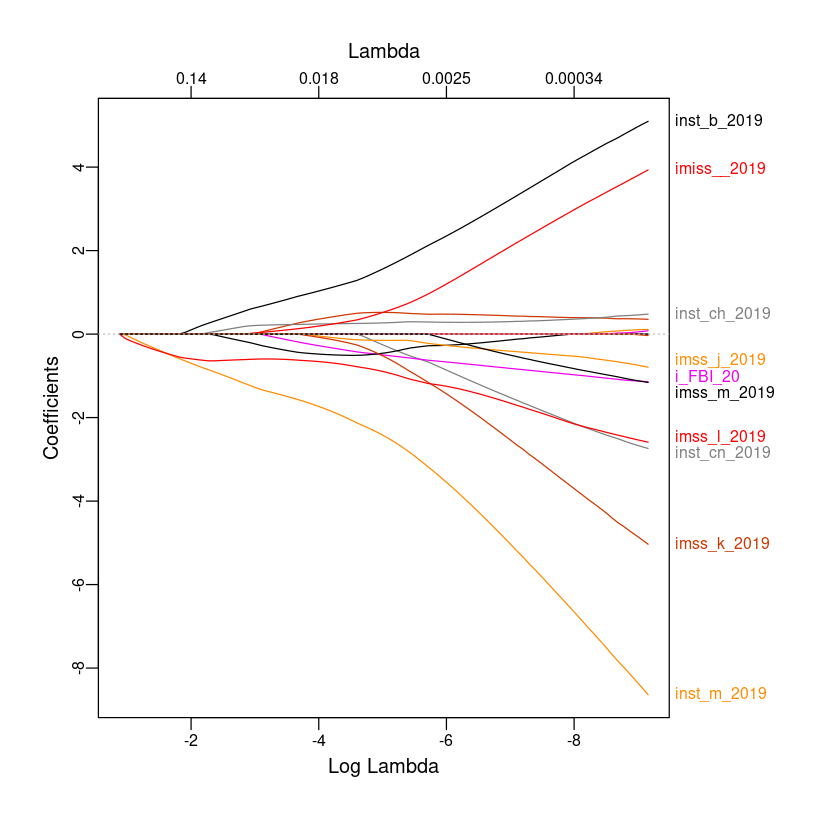

In [74]:
plotmo::plot_glmnet(x = model_lasso)

In [75]:
coef_lasso <- model_lasso$beta

In [76]:
coef_lasso

   [[ suppressing 90 column names ‘s0’, ‘s1’, ‘s2’ ... ]]



29 x 90 sparse Matrix of class "dgCMatrix"
                                                                             
add_confirm_2019   .  .           .           .          .          .        
izip_2019          .  .           .           .          .          .        
votereg_2019       .  .           .           .          .          .        
votereg_f_2019     .  .           .           .          .          .        
regzip_2019        .  .           .           .          .          .        
region_2019        .  .           .           .          .          .        
inst_court_2019    .  .           .           .          .          .        
inst_media_2019    . -0.01816929 -0.08902152 -0.1565201 -0.2214647 -0.2844773
inst_congress_2019 .  .           .           .          .          .        
inst_justice_2019  .  .           .           .          .          .        
inst_FBI_2019      .  .           .           .          .          .        
inst_military_2019 . 

In [87]:
y_train <- set_train[,1]
predict_train <- predict.glmnet(object = model_lasso, newx = data.matrix(set_train[,-1]))
MSE_train <- mean((y_train - predict_train)^2) # Brier score

Warning message in Ops.factor(left, right):
“‘-’ not meaningful for factors”
Warning message in mean.default((y_train - predict_train)^2):
“argument is not numeric or logical: returning NA”


In [88]:
colnames(predict_train)

[1] "s0"  "s1"  "s2"  "s3"  "s4"  "s5"  "s6"  "s7"  "s8"  "s9"  "s10" "s11"
[13] "s12" "s13" "s14" "s15" "s16" "s17" "s18" "s19" "s20" "s21" "s22" "s23"
[25] "s24" "s25" "s26" "s27" "s28" "s29" "s30" "s31" "s32" "s33" "s34" "s35"
[37] "s36" "s37" "s38" "s39" "s40" "s41" "s42" "s43" "s44" "s45" "s46" "s47"
[49] "s48" "s49" "s50" "s51" "s52" "s53" "s54" "s55" "s56" "s57" "s58" "s59"
[61] "s60" "s61" "s62" "s63" "s64" "s65" "s66" "s67" "s68" "s69" "s70" "s71"
[73] "s72" "s73" "s74" "s75" "s76" "s77" "s78" "s79" "s80" "s81" "s82" "s83"
[85] "s84" "s85" "s86" "s87" "s88" "s89"